In [26]:
import subprocess
import numpy as np
import simplifier
import csv
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import rc
import matplotlib.cm as cm
import matplotlib as mpl
import sympy

# Figure 2 - Number of functions vs Complexity

In [ ]:
def file_len(fname):
    p = subprocess.Popen(['wc', '-l', fname], stdout=subprocess.PIPE,
                                              stderr=subprocess.PIPE)
    result, err = p.communicate()
    if p.returncode != 0:
        raise IOError(err)
    return int(result.strip().split()[0])


def count_fun(fname):

    ntotal = file_len(fname)
    with open(fname, "r") as f:
        all_fun = f.read().splitlines()
    assert ntotal == len(all_fun), 'Maybe missing some equations'
    max_param = simplifier.get_max_param(all_fun, verbose=False)
    nparam = simplifier.count_params(all_fun, max_param)
    count = np.empty(max_param + 1, dtype=int)
    for i in range(len(count)):
        count[i] = (nparam == i).sum()
    assert ntotal == count.sum(), 'Count does not match total'

    return count

all_compl = np.arange(4, 11)
# all_compl = np.arange(4, 8)
# all_dirname = ['core_maths/', 'osc_maths/', 'ext_maths/']
# all_ops = [r'Core = $\{x, a, {\rm inv}, +, -, \times, \div, {\rm pow} \}$',
#           r'Core + $\{ \sin \}$',
#           r'Core + $\{ {\rm square}, \exp, \sqrt{\cdot} \}$']
all_dirname = ['core_maths/']
all_ops = [r'$\{x, a, {\rm inv}, +, -, \times, \div, {\rm pow} \}$']

nfortab = 4

# fig, axs = plt.subplots(1, 3, figsize=(10,3), sharey=True)
fig, axs = plt.subplots(1, 1, figsize=(5,4))
axs = [axs]
cm = plt.get_cmap('Set1')

for i in range(len(all_dirname)):
    
    dirname = all_dirname[i]
    ops = all_ops[i]

    all_total = []
    all_uniq = []
    
    print(dirname)

    for compl in all_compl:

        print(compl)

        try:
            fname = dirname + '/compl_%i/all_equations_%i.txt'%(compl,compl)
            total_count = count_fun(fname)

            fname = dirname + '/compl_%i/unique_equations_%i.txt'%(compl,compl)
            uniq_count = count_fun(fname)

            if (len(uniq_count) < nfortab+1) or (len(total_count) < nfortab+1):
                t = np.zeros(nfortab+1, dtype=int)
                t[:len(uniq_count)] = uniq_count
                uniq_count = t

                t = np.zeros(nfortab+1, dtype=int)
                t[:len(total_count)] = total_count
                total_count = t

            all_total.append([x for x in total_count[:nfortab+1]])
            all_uniq.append([x for x in uniq_count[:nfortab+1]])

        except:
            pass


    all_total = np.array(all_total, dtype=int)
    all_uniq = np.array(all_uniq, dtype=int)
    
    for j in range(all_total.shape[1]):
        c = cm(j)
        axs[i].plot(all_compl[:all_total.shape[0]], all_total[:,j], color=c, marker='.', label=r'$p = %i$'%j)
        axs[i].plot(all_compl[:all_total.shape[0]], all_uniq[:,j], color=c, ls='--', marker='.')
        
    axs[i].set_xlabel('Complexity')
    axs[i].set_title(ops)
    
    axs[i].set_xticks(all_compl)
    axs[i].set_xticklabels(all_compl)

axs[0].set_yscale('symlog')
axs[0].set_ylabel('Number of Functions')
axs[0].set_ylim(0, None)

fig.tight_layout()
fig.subplots_adjust(hspace=0)

# axs[int(np.floor(len(axs)/2))].legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=nfortab+1, fancybox=True)
axs[int(np.floor(len(axs)/2))].legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=nfortab+1, fancybox=True)
fig.savefig('figs/count_functions.pdf', bbox_inches='tight', transparent=True)

# Figure 4 - Pareto Front Comparison 

/mnt/zfsusers/deaglan/symbolic_regression/brute_force/simplify_brute/Pantheon/output_panth/
BEST FUNCTION (MDL): ['a0 + pow(x,x)', ['0.19592785', '0.0', '0.0', '0.0']]
BEST FUNCTION (logL): ['a0 - x + pow(x,a1)', ['1.1793247', '2.188762', '0.0', '0.0']]
/mnt/zfsusers/deaglan/symbolic_regression/brute_force/simplify_brute/Pantheon/output_cc/
BEST FUNCTION (MDL): ['pow(x,(pow(x,a0)))', ['0.7161692', '0.0', '0.0', '0.0']]
BEST FUNCTION (logL): ['1/(a0 + pow(Abs(a1),(pow(Abs(a2),x))))', ['0.17060539', '-0.96293526', '8.0563284', '0.0']]


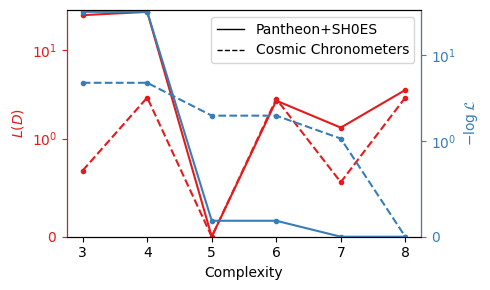

In [12]:
root_dirname = '/mnt/zfsusers/deaglan/symbolic_regression/brute_force/simplify_brute/Pantheon/'

all_dirname = ['output_panth/', 'output_cc/']
all_ls = ['-', '--']
line_labels = ['Pantheon+SH0ES', "Cosmic Chronometers"]

# all_dirname = ['output_cc/']
# all_ls = ['-']
# line_labels = ["Cosmic Chronometers"]

all_compl = np.arange(3, 9)
               
fig, ax1 = plt.subplots(1, 1, figsize=(5,3))
ax2 = ax1.twinx()
cm = plt.get_cmap('Set1')
               
for k in range(len(all_dirname)):
               
    dirname = root_dirname + all_dirname[k]
    print(dirname)
               
    DL = np.empty(len(all_compl))
    logL = np.empty(len(all_compl))
    DL_fun = [None] * len(all_compl)
    logL_fun = [None] * len(all_compl)

    for i, compl in enumerate(all_compl):
        fname = dirname + 'final_%i.dat'%compl
        with open(fname, "r") as f:
            reader = csv.reader(f, delimiter=';')
            data = [row for row in reader]
            ll = np.array([d[4] for d in data], dtype=float)
            j = np.nanargmin(ll)
            logL[i] = ll[j]
            logL_fun[i] = [data[j][1], data[j][7:]]

        DL[i] = data[0][2]
        DL_fun[i] = [data[0][1], data[0][7:]]

    print('BEST FUNCTION (MDL):', DL_fun[np.argmin(DL)])
    print('BEST FUNCTION (logL):', logL_fun[np.argmin(logL)])
    
    DL -= np.amin(DL)
    logL -= np.amin(logL)

    ax1.plot(all_compl, DL, marker='.', color=cm(0), ls=all_ls[k])
    ax2.plot(all_compl, logL, marker='.', color=cm(1), ls=all_ls[k])
    

ax1.set_ylabel(r'$L \left( D \right)$')
ax1.set_xticks(all_compl)
ax1.set_xticklabels(all_compl);
ax1.set_xlabel(r'Complexity')
               
ax2.set_ylabel(r'$ - \log\mathcal{L}$')
ax1.yaxis.label.set_color(cm(0))
ax1.tick_params(axis='y', colors=cm(0))
ax2.spines['left'].set_color(cm(0))

ax2.yaxis.label.set_color(cm(1))
ax2.tick_params(axis='y', colors=cm(1))
ax2.spines['right'].set_color(cm(1))

custom_lines = []
for i in range(len(all_ls)):
    custom_lines.append(Line2D([0], [0], color='k', lw=1, ls=all_ls[i]))
    
ax1.legend(custom_lines, line_labels, fancybox=True)
ax1.set_yscale('symlog', linthresh=1)
ax1.set_ylim(0, None)
ax2.set_yscale('symlog', linthresh=1)
ax2.set_ylim(0, None)
                
fig.tight_layout()
    

# Tabulate the Best Functions

In [52]:
root_dirname = '/mnt/zfsusers/deaglan/symbolic_regression/brute_force/simplify_brute/Pantheon/'
all_dirname = ['output_panth/', 'output_cc/']

all_dirname = [root_dirname + d for d in all_dirname]

for dirname in all_dirname:

    all_compl = np.arange(3, 9)

    nrow = 5

    DL = []
    logL = []
    fun = []
    params = []

    for i, compl in enumerate(all_compl):
        fname = dirname + 'final_%i.dat'%compl
        with open(fname, "r") as f:
            reader = csv.reader(f, delimiter=';')
            data = [row for row in reader]

            DL += [d[2] for d in data]
            logL += [d[4] for d in data]
            fun += [d[1] for d in data]
            params += [d[7:] for d in data]

    DL = np.array(DL, dtype=float)
    logL = np.array(logL, dtype=float)
    params = np.array(params, dtype=float)

    m = np.argsort(DL)
    DL = DL[m]
    logL = logL[m]
    params = params[m,:]
    fun = [fun[i] for i in m]

    x, y = sympy.symbols('x y', positive=True)                  # The variables, which are always +ve here
    a0, a1, a2, a3 = sympy.symbols('a0 a1 a2 a3', real=True)    # The constants, which can be -ve
    sympy.init_printing(use_unicode=True)
    inv = sympy.Lambda(x, 1/x)
    square = sympy.Lambda(x, x*x)
    cube = sympy.Lambda(x, x*x*x)
    sqrt = sympy.Lambda(x, sympy.sqrt(sympy.Abs(x, evaluate=False)))
    log = sympy.Lambda(x, sympy.log(sympy.Abs(x, evaluate=False)))
    pow = sympy.Lambda((x,y), sympy.Pow(sympy.Abs(x, evaluate=False), y))

    sympy.init_printing(use_latex=True)

    # CONVERT TO LATEX
    # for i in range(nrow):
    from sympy.printing.latex import LatexPrinter
    texprinter = LatexPrinter()

    form = 'c|c|c|c'
    labs = 'Rank & Function & $L\\left(D\\right)$ & $-\\log\\mathcal{L}$'
    for i in range(params.shape[1]):
        form += '|c'
        labs += ' & $\\theta_{%i}$'%i
    labs += '\\\\'

    print('\t\t\\begin{tabular}{%s}'%form)
    print('\t\t\\hline')
    print('\t\t' + labs)

    for i in range(nrow):

        fcn_i = fun[i]
        fcn_i = fcn_i.replace('\n', '')
        fcn_i = fcn_i.replace('\'', '')

        eq = sympy.sympify(fcn_i,
                        locals={"inv": inv,
                                "square": square,
                                "cube": cube,
                                "sqrt": sqrt,
                                "log": log,
                                "pow": pow,
                                "x": x,
                                "a0": a0,
                                "a1": a1,
                                "a2": a2})
        f = texprinter.doprint(eq)
        f = '$' + f.replace('a_', '\\theta_') + '$'

        if 'a3' in fcn_i:
            npar = 4
        elif 'a2' in fcn_i:
            npar = 3
        elif 'a1' in fcn_i:
            npar = 2
        elif 'a0' in fcn_i:
            npar = 1
        else:
            npar = 0

        s = ''
        for j in range(len(params[i,:])):
            if j < npar:
                s += '%.2f & '%params[i,j]
            else:
                s += '- & '
        s = s[:-2]
        s = '\t\t\t%i & %s & %.2f & %.2f & %s \\\\'%(i+1, f, DL[i], logL[i], s)

        print(s)

    print('\t\t\\hline') 
    print('\t\t\\end{tabular}')

    print('\n\n')


		\begin{tabular}{c|c|c|c|c|c|c|c}
		\hline
		Rank & Function & $L\left(D\right)$ & $-\log\mathcal{L}$ & $\theta_{0}$ & $\theta_{1}$ & $\theta_{2}$ & $\theta_{3}$\\
			1 & $\theta_{0} + x^{x}$ & 716.48 & 706.33 & 0.20 & - & - & -  \\
			2 & $\left|{\theta_{0} + x}\right|^{x}$ & 716.59 & 706.44 & 0.18 & - & - & -  \\
			3 & $x \left|{\theta_{0}}\right|^{x^{2}}$ & 717.81 & 702.77 & 1.16 & - & - & -  \\
			4 & $\left|{\theta_{0} + x}\right|^{x^{\theta_{1}}}$ & 717.84 & 702.68 & 0.18 & 0.82 & - & -  \\
			5 & $\theta_{0} x^{x}$ & 718.22 & 706.18 & 1.18 & - & - & -  \\
		\hline
		\end{tabular}



		\begin{tabular}{c|c|c|c|c|c|c|c}
		\hline
		Rank & Function & $L\left(D\right)$ & $-\log\mathcal{L}$ & $\theta_{0}$ & $\theta_{1}$ & $\theta_{2}$ & $\theta_{3}$\\
			1 & $x^{x^{\theta_{0}}}$ & 15.33 & 7.91 & 0.72 & - & - & -  \\
			2 & $x^{x^{x^{\theta_{0}}}}$ & 15.88 & 7.38 & -0.38 & - & - & -  \\
			3 & $x^{\theta_{0}}$ & 16.00 & 10.34 & 1.73 & - & - & -  \\
			4 & $x^{\theta_{0}}$ & 16.00 & 10